# Лабораторная работа № 2

# Блочное симметричное шифрование

## Вариант

3(в)

## Задание 

Реализовать систему симметричного блочного шифрования,
позволяющую шифровать и дешифровать файл на диске с использованием
блочного шифра RC6 в режиме шифрования PCBC. 

# Получение слова и шифра


In [1]:
print("Введите ключ:")
key = input()

print("Введите фразу для шифрования:")
phrase = input()

# Приведение ключа к необходимому размеру
if (len(key) != 16):
    print("Корректировка ключа...")
for i in range(len(key), 16):
    key += " "
key = key[:16]
print(f'Ключ: "{key}"')

# Приведение фразы к необходимому размеру
if (len(phrase) != 16):
    print("Корректировка фразы...")
for i in range(len(phrase), 16):
    phrase += " "
phrase = phrase[:16]
print(f'Фраза: "{phrase}"')

Введите ключ:
it is key
Введите фразу для шифрования:
this is my words
Корректировка ключа...
Ключ: "it is key       "
Фраза: "this is my words"


# Константы

$ w $ - размер слова в битах. Блоки открытого текста и шифротекста имеют длину $ 4w $ - бит (т.к. 4 регистра).

$ r $ - количество раундов. Так же размер расширенного массива ключей $ S $ будет иметь $ t=(2r+4) $ слово. Допустимые значения $ 0\leq r\leq 255 $. 

$ b $ - количество байт в секретном ключе $ K $.

$ K $ - секретный ключ размеров $ b $ байт: $K[0], K[1], ... , K[b-1] $.

In [2]:
import math

w = 32
r = 12
b = len(key)
K = []
W = []

# Ключ
print("КЛЮЧ:")
for i in range(0, b):
    K.append(ord(key[i]))
    print(f'{key[i]} -> {bin(K[i])}')
    
# фраза
print("\nФРАЗА:")
for i in range(0, len(phrase)):
    W.append(ord(phrase[i]))
    print(f'{phrase[i]} -> {bin(W[i])}')

# Неизменяемые параметры
# количество байт в слове
u = w/8
# Размер расширинного размера ключей
t = 2 * r + 4

КЛЮЧ:
i -> 0b1101001
t -> 0b1110100
  -> 0b100000
i -> 0b1101001
s -> 0b1110011
  -> 0b100000
k -> 0b1101011
e -> 0b1100101
y -> 0b1111001
  -> 0b100000
  -> 0b100000
  -> 0b100000
  -> 0b100000
  -> 0b100000
  -> 0b100000
  -> 0b100000

ФРАЗА:
t -> 0b1110100
h -> 0b1101000
i -> 0b1101001
s -> 0b1110011
  -> 0b100000
i -> 0b1101001
s -> 0b1110011
  -> 0b100000
m -> 0b1101101
y -> 0b1111001
  -> 0b100000
w -> 0b1110111
o -> 0b1101111
r -> 0b1110010
d -> 0b1100100
s -> 0b1110011


In [3]:
# Реализация циклических сдвигов вправо/влево

# rotate right input x, by n bits
def ROR(x, n, bits = 32):
    mask = (2**n) - 1
    mask_bits = x & mask
    return (x >> n) | (mask_bits << (bits - n))

#rotate left input x, by n bits
def ROL(x, n, bits = 32):
    return ROR(x, bits - n,bits)

# Подготовка ключа

генерация констант

Для конкретного w мы определяем две величины:

$$ P_w \leftarrow Odd((e-2)2^w)\\Q_w \leftarrow Odd((\phi-1)2^w) $$

где $ e=2.71828... $(экспонента), $ \phi=1.61803... $ (золотое сечение). 

$ Odd(\cdot) $ - операция округления до ближайшего нечетного целого.

In [4]:
# операция округления до ближайшего нечетного целого
def odd(x):
    if x - math.trunc(x) == 0:
        return x + 1
    return math.ceil(x) if math.ceil(x) % 2 == 1 else math.floor(x)

# константа золотого сечения
phi = (1 + 5 ** 0.5) / 2

# генерация констант
p_w = odd( (math.e - 2) * math.pow(2, w) )
q_w = odd( (phi - 1) * math.pow(2, w) ) 

print(f'P_w = {bin(p_w)}\nQ_w = {bin(q_w)}')

P_w = 0b10110111111000010101000101100011
Q_w = 0b10011110001101110111100110111001


# Конвертация секретного ключа

На первом этапе нужно скопировать секретный ключ из массива $ K[0...b-1] $ в массив $ L[0...c-1] $, который состоит из $c=b/u$ слов, где $u=w/8$-количество байт в слове. Если   $b$ не кратен $w / 8$, то $L$дополняется нулевыми битами до ближайшего большего кратного:

In [5]:
c = math.ceil(max(b, 1) / u)
print(f'c = {c}')

L = []
for i in range(0, c):
    L.append(0)
    for j in range(0, math.trunc(b/c)):
        L[i] = ROL(L[i], 8) + K[math.trunc(i * u + j)]         
    print(f'L[{i}] = {bin(L[i])}')

print(f'Конвертация секретного ключа: {L}')

c = 4
L[0] = 0b1101001011101000010000001101001
L[1] = 0b1110011001000000110101101100101
L[2] = 0b1111001001000000010000000100000
L[3] = 0b100000001000000010000000100000
Конвертация секретного ключа: [1769218153, 1931504485, 2032148512, 538976288]


# Инициализация массива ключей

Массив ключей $S$ так же называют расширенной таблицей ключей. Она заполняется с помощью тех самых магических констант, которые мы определили ранее:

In [6]:
S = []
S.append(p_w)

for i in range(1, t):
    S.append((S[i-1] + q_w) % (2**w))
    print(f'S[{i}] = {bin(S[i])} ({S[i]}_10)')

S[1] = 0b1010110000110001100101100011100 (1444465436_10)
S[2] = 0b11110100010100000100010011010101 (4098901205_10)
S[3] = 0b10010010100001111011111010001110 (2458369678_10)
S[4] = 0b110000101111110011100001000111 (817838151_10)
S[5] = 0b11001110111101101011001000000000 (3472273920_10)
S[6] = 0b1101101001011100010101110111001 (1831742393_10)
S[7] = 0b1011011001011010010101110010 (191210866_10)
S[8] = 0b10101001100111010001111100101011 (2845646635_10)
S[9] = 0b1000111110101001001100011100100 (1205115108_10)
S[10] = 0b11100110000011000001001010011101 (3859550877_10)
S[11] = 0b10000100010000111000110001010110 (2219019350_10)
S[12] = 0b100010011110110000011000001111 (578487823_10)
S[13] = 0b11000000101100100111111111001000 (3232923592_10)
S[14] = 0b1011110111010011111100110000001 (1592392065_10)
S[15] = 0b11111101001000010111001100111010 (4246827834_10)
S[16] = 0b10011011010110001110110011110011 (2606296307_10)
S[17] = 0b111001100100000110011010101100 (965764780_10)
S[18] = 0b11010111110001

# Перемешивание

Этот шаг состоит в том, чтобы перемешать секретный ключ, который нам дал пользователь. 

На выходу получаем w-битный массив ключей S[0,...,t]

In [7]:
A = B = C = D = i = j = 0

l = L[::-1]
s = S[:]

v = 3 * max(c, t)

for q in range(0, v):
    A = s[i] = ROL((s[i] + A + B) % 2**32 , 3)
    B = l[j] = ROL((l[j] + A + B) % 2**32, (A + B) % 32)
    i = (i + 1) % t
    j = (j + 1) % c

print(f'Массив ключей S: {s}')

Массив ключей S: [2106657397, 845325853, 3161286223, 3247034139, 1288545522, 2015828968, 2472217794, 2487785523, 237685967, 2332935534, 738826631, 2495182138, 867466952, 4011142852, 326828175, 3037555482, 2711698378, 514328036, 1510940806, 1289201715, 4217130091, 4174856704, 1921760813, 360589565, 1098378974, 3355465680, 942809185, 2110393303]


# Подготовка фразы

В регистрах А, В, С, D должна хранится фраза.

In [8]:
L1 = []
cur = 0
for i in range(0, 4):
    L1.append(0)
    for j in range(0, math.trunc(b/4)):
        L1[i] = ROL(L1[i], 8) + W[cur]
        cur += 1
    print(f'L1[{i}] = {bin(L1[i])}')

L1[0] = 0b1110100011010000110100101110011
L1[1] = 0b100000011010010111001100100000
L1[2] = 0b1101101011110010010000001110111
L1[3] = 0b1101111011100100110010001110011


# Шифрование

A, B, C, D содержат исходный входной открытый текст, а также выходной шифротекст. Причем первый байт открытого текста или шифротекста помещается в младший байт A, а последний байт в самый старший байт D.

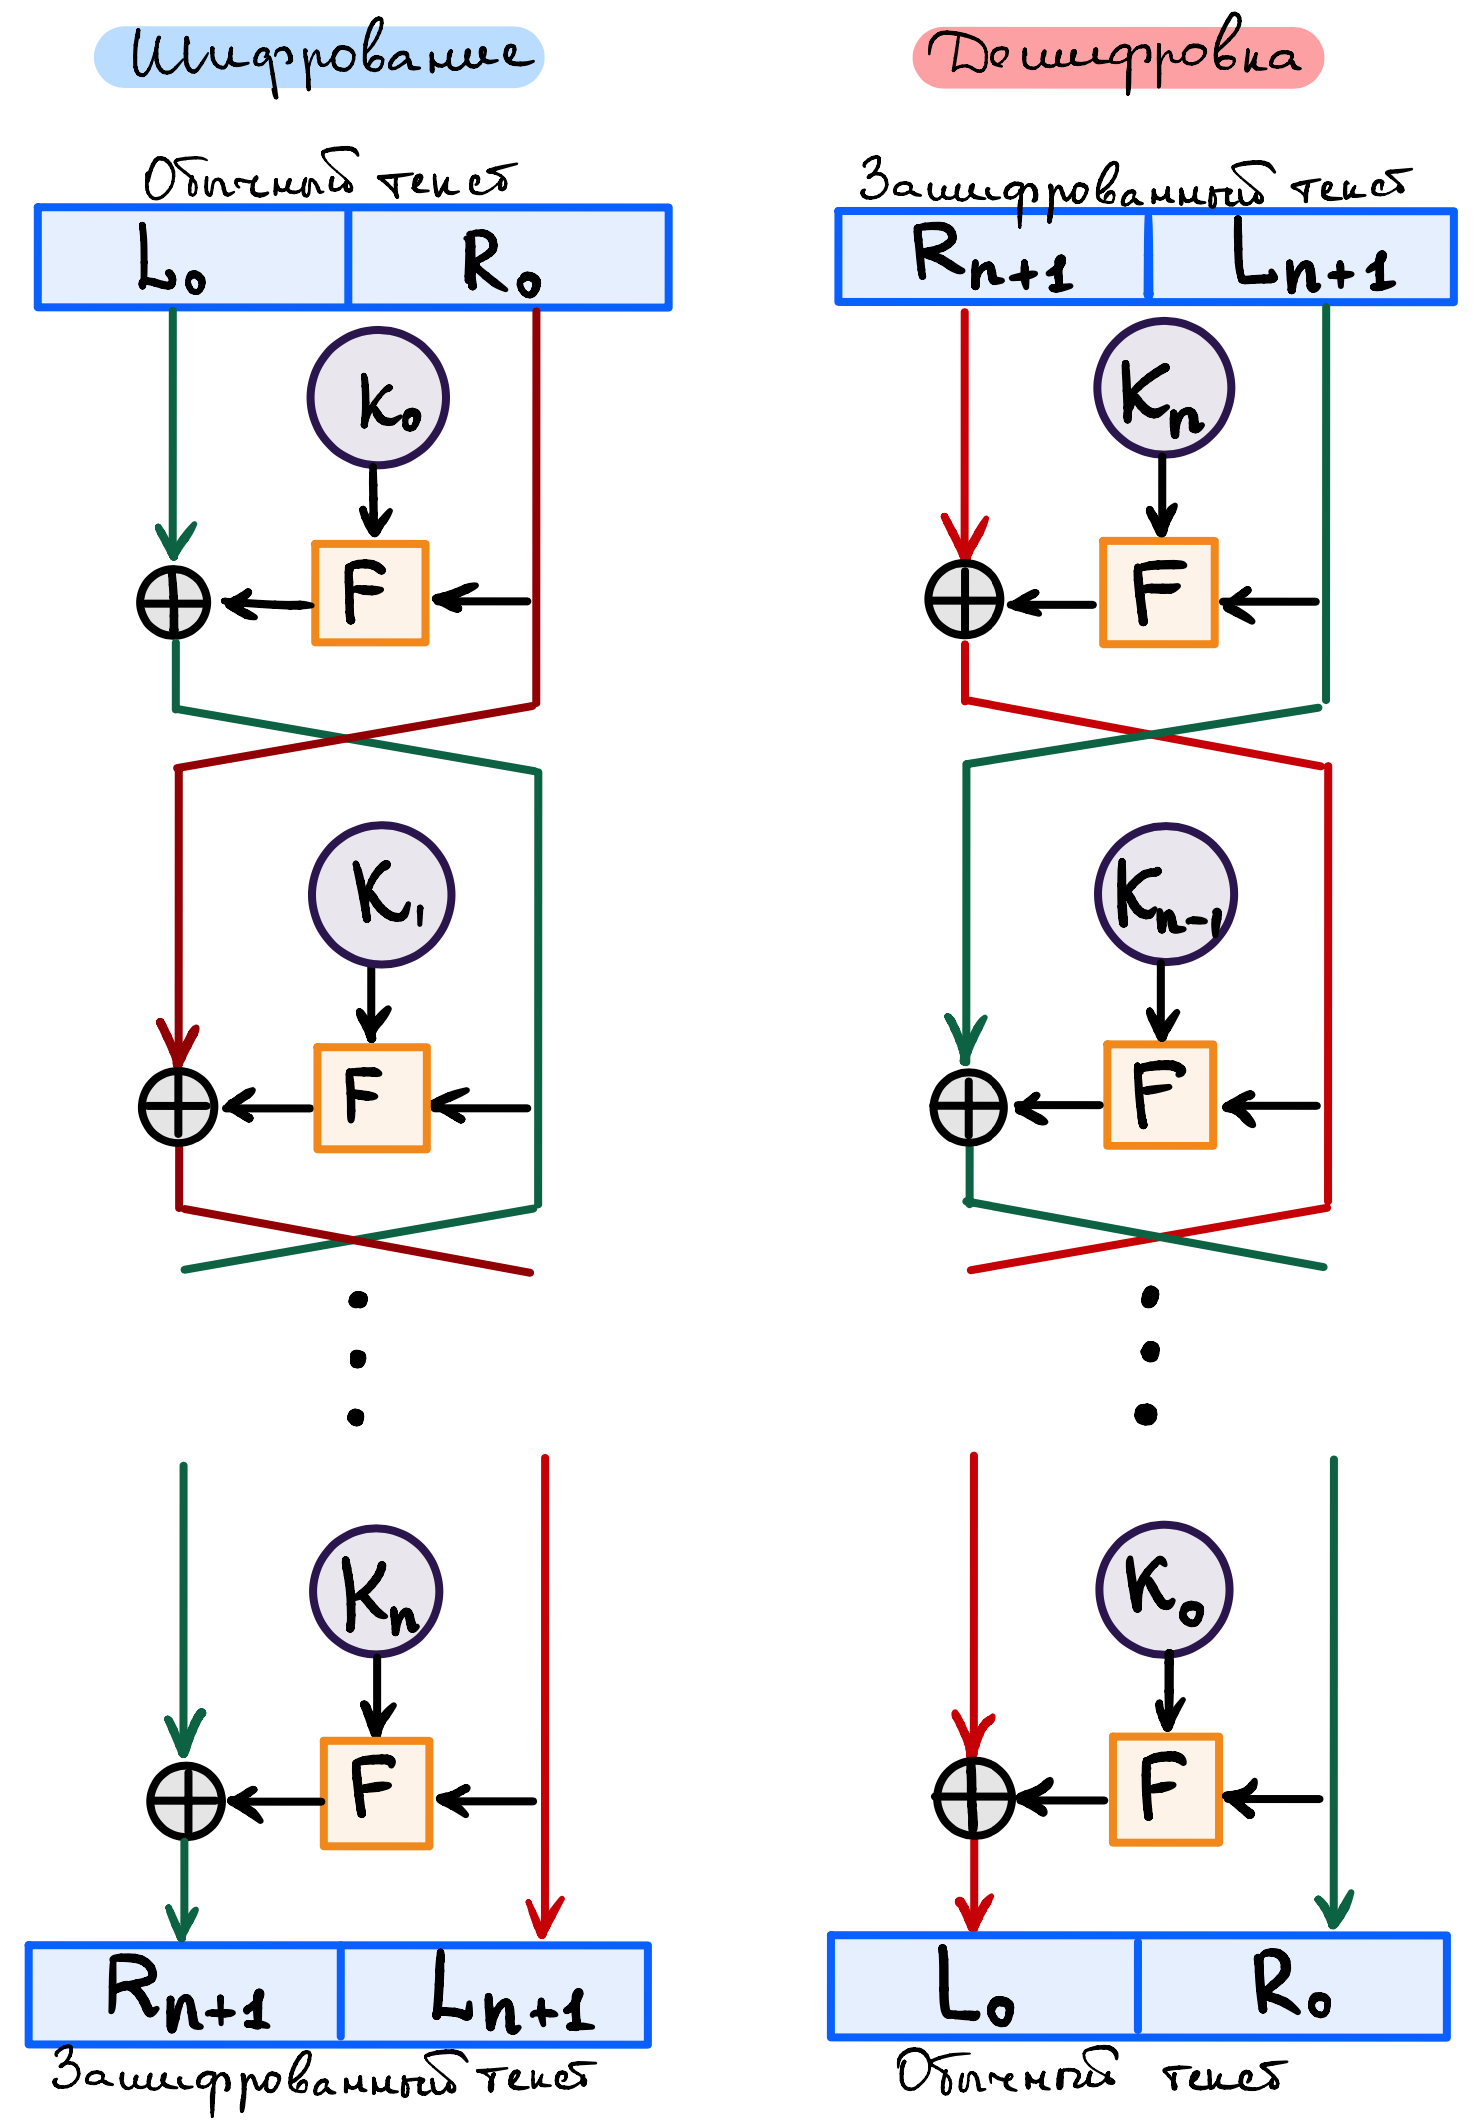

In [9]:
A, B, C, D = L1[0], L1[1], L1[2], L1[3]

B = (B + s[0]) % 2**32
D = (D + s[1]) % 2**32

def shafl(X1, X2, X3, X4):
    return X1, X2, X3, X4

for i in range(1, r + 1):
    print([A, B, C, D])
    temp = ROL((B * (2 * B + 1)) % 2**32, int(math.log(w, 2)))
    u_temp = ROL((D * (2 * D + 1)) % 2**32, int(math.log(w, 2)))
    A = ROL( (A ^ temp) % 2**32, u_temp % 32) + s[2 * i]
    C = ROL( (C ^ u_temp) % 2**32 , temp % 32) + s[2*i + 1]
    A, B, C, D = shafl(B, C, D, A) #  (A, B, C, D) = (B, C, D, A)
                                   #  -- параллельное присвоения значений.
A = (A + s[2*r + 2]) % 2**32
C = (C + s[2*r + 3]) % 2**32

encode = [A, B, C, D]
print(f'A = {A},\nB = {B},\nC = {C},\nD = {D}')

[1952999795, 2650439061, 1836654711, 2715093648]
[2650439061, 5387591141, 2715093648, 3813177723]
[5387591141, 3903230182, 3813177723, 3789361472]
[3903230182, 3912085383, 3789361472, 4452476519]
[3912085383, 4064503462, 4452476519, 2474753095]
[4064503462, 5219910735, 2474753095, 2249375448]
[5219910735, 7026939262, 2249375448, 3169799031]
[7026939262, 6824745639, 3169799031, 3974371920]
[6824745639, 3020273212, 3974371920, 4995087018]
[3020273212, 1422266008, 4995087018, 3802638953]
[1422266008, 6002784230, 3802638953, 6389077299]
[6002784230, 3838350359, 6389077299, 5451976245]
A = 486192248,
B = 4799472249,
C = 3267402252,
D = 3735868223


Получение зашифрованной фразы из A, B, C, D:

In [10]:
res = ""
for e in encode:
    temp =bin(e)[2:]
    if len(temp) <32:
        temp = "0"*(32-len(temp)) + temp
    for i in range(0,4):
        res=res+chr(int(temp[i*8:(i+1)*8],2))

print(f'Готовая зашифроаванная фраза: "{res}"')

Готовая зашифроаванная фраза: "ú´x	<ÂÀÞ¬Ó?"


# Дешифрование

Вход: 

- Зашифрованный текст в 4-х w-битных регистрах A, B, C, D

- Количество раундов r

- w-битный массив ключей S[0,...,2r+3]

Выход: 

- Открытый текст, хранящийся в A, B, C, D

In [11]:
A, B, C, D = encode[0], encode[1], encode[2], encode[3]

C = (C - s[2*r + 3]) % 2**32
A = (A - s[2*r + 2]) % 2**32

for i in reversed(range(1, r + 1)):
    A, B, C, D = shafl(D, A, B, C)   #  (A, B, C, D) = (D, A, B, C) 
                                     #  -- параллельное присвоения значений.
    u_temp = ROL((D * (2*D + 1)) % 2**32, int(math.log(w, 2)))
    temp = ROL((B * (2*B + 1)) % 2**32, int(math.log(w, 2)))
    C = (ROR((C - s[2*i + 1]) % 2**32, temp % 32) ^ u_temp)
    A = (ROR((A - s[2*i]) % 2**32, u_temp % 32) ^ temp)

D = (D - s[1]) % 2**32
B = (B - s[0]) % 2**32

decode = [A, B, C, D]
print(f'A = {A}, \nB = {B}, \nC = {C}, \nD = {D}')

A = 1952999795, 
B = 543781664, 
C = 1836654711, 
D = 1869767795


Расшифрованная фраза:

In [12]:
res1 = ""
for e in decode:
    temp =bin(e)[2:]
    if len(temp) <32:
        temp = "0"*(32-len(temp)) + temp
    for i in range(0,4):
        res1=res1+chr(int(temp[i*8:(i+1)*8],2))

print(f'Готовая расшифроаванная фраза: "{res1}"')

Готовая расшифроаванная фраза: "this is my words"
